Predicción de la evolución de la diabetes usando PySpark (MLlib: RDD-based)
===

* *30 min* | Última modificación: Noviembre 6, 2020

Definición del problema
--

Los modelos de regresión son ampliamente usados para la construcción de modelos de pronóstico para toma de decisiones. En este caso particular, el médico desearía tener un pronóstico del progreso de la diabetes con un horizonte de doce meses de sus pacientes con base en variables físicas y pruebas de laboratorio, con el fin de realizar mejores tratamientos. Véase https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

En este problema se tiene una base de datos de diez variables base (edad, sexo, índice de masa corporal, presión arterial, y seis variables medidas en sangre) para 442 pacientes, y un índice que mide el progreso de la diabetes un año después de la prueba. La información se encuentra en el archivo `diabetes.csv`. Se desea construir un modelo de regresión que permita pronosticar la evolución de la enfermedad con la información disponible.Se desea construir un modelo de regresión que permita pronosticar la evolución de la enfermedad con la información disponible.

Preparación del archivo de datos
--

In [1]:
#
# Descarga
#
!wget https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/diabetes.csv

--2020-11-05 20:26:21--  https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88791 (87K) [text/plain]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>]  86.71K  --.-KB/s    in 0.1s    

2020-11-05 20:26:21 (800 KB/s) - ‘diabetes.csv’ saved [88791/88791]



In [2]:
#
# Contenido del archivo
#
!head diabetes.csv

age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0.0380759064334241,0.0506801187398187,0.0616962065186885,0.0218723549949558,-0.0442234984244464,-0.0348207628376986,-0.0434008456520269,-0.00259226199818282,0.0199084208763183,-0.0176461251598052,151.0
-0.00188201652779104,-0.044641636506989,-0.0514740612388061,-0.0263278347173518,-0.00844872411121698,-0.019163339748222,0.0744115640787594,-0.0394933828740919,-0.0683297436244215,-0.09220404962683,75.0
0.0852989062966783,0.0506801187398187,0.0444512133365941,-0.00567061055493425,-0.0455994512826475,-0.0341944659141195,-0.0323559322397657,-0.00259226199818282,0.00286377051894013,-0.0259303389894746,141.0
-0.0890629393522603,-0.044641636506989,-0.0115950145052127,-0.0366564467985606,0.0121905687618,0.0249905933641021,-0.0360375700438527,0.0343088588777263,0.0226920225667445,-0.0093619113301358,206.0
0.00538306037424807,-0.044641636506989,-0.0363846922044735,0.0218723549949558,0.00393485161259318,0.0155961395104161,0.0081420836051921,-0.00259226199818282,-

In [3]:
#
# Remueve la primera fila del archivo
#
!sed '1d'  diabetes.csv >  diabetes0.csv

In [4]:
#
# Mueve el archivo de datos al hdfs
#
!hdfs dfs -copyFromLocal diabetes0.csv /tmp/diabetes.csv

Inicialización de Spark
--

In [5]:
#
# Carga de las librerías de Spark
#
import findspark
from pyspark.sql import SparkSession

from pyspark import SparkConf, SparkContext

findspark.init()

APP_NAME = "spark-app"

conf = SparkConf().setAppName(APP_NAME)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

Carga de datos
--

In [6]:
rdd = sc.textFile("/tmp/diabetes.csv")

rdd = rdd.map(lambda w: w.split(","))

Análisis exploratorio
--

In [7]:
#
# Estadísitcas básicas
#
import numpy as np
import pandas as pd
from pyspark.mllib.stat import Statistics

x = rdd.map(lambda w: np.array(w))
summary = Statistics.colStats(x)

pd.DataFrame(
    {
        "Mean": summary.mean(),
        "Var": summary.variance(),
        "Max": summary.max(),
        "Min": summary.min(),
        "Count": summary.count(),
        "numNonZero": summary.numNonzeros(),
    },
    index=["age", "sex", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6", "Y"],
).transpose()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
Mean,-3.642919e-16,1.288032e-16,-8.023096e-16,1.281527e-16,-8.977194e-17,1.322727e-16,-4.565575e-16,3.872770e-16,-3.885781e-16,-3.404395e-16,152.133484
Var,2.267574e-03,2.267574e-03,2.267574e-03,2.267574e-03,2.267574e-03,2.267574e-03,2.267574e-03,2.267574e-03,2.267574e-03,2.267574e-03,5943.331348
Max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000
Min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
Count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
numNonZero,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000


In [8]:
#
# histograma.
# Muestra que la mayor parte de la población tiene
# gastos bajos, mientras que disminuye la frecuencia
# de costos más altos es más baja.
#
# La función histogram de pyspark permite computar
# los datos de graficación del histograma, pero
# no grafica el histograma como tal.
#
h = rdd.map(lambda w: float(w[10])).histogram(11)
h

([25.0,
  54.18181818181819,
  83.36363636363637,
  112.54545454545455,
  141.72727272727275,
  170.9090909090909,
  200.0909090909091,
  229.27272727272728,
  258.4545454545455,
  287.6363636363636,
  316.8181818181818,
  346.0],
 [33, 68, 71, 52, 46, 51, 29, 36, 35, 15, 6])

In [ ]:
!pip3 install -q  matplotlib

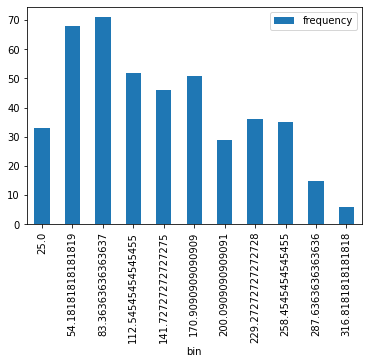

In [9]:
#
# Debe recurrise a Pandas para realizar la
# graficación
#
pd.DataFrame(list(zip(*h)), columns=["bin", "frequency"]).set_index("bin").plot(
    kind="bar"
);

In [10]:
#
# Cómputo de la correlación entre
# las variables numéricas del DataFrame
#
Statistics.corr(rdd, method="pearson")

array([[ 1.        ,  0.1737371 ,  0.18508467,  0.33542671,  0.26006082,
         0.21924314, -0.07518097,  0.2038409 ,  0.27077678,  0.30173101,
         0.18788875],
       [ 0.1737371 ,  1.        ,  0.0881614 ,  0.24101317,  0.03527682,
         0.14263726, -0.37908963,  0.33211509,  0.14991756,  0.20813322,
         0.043062  ],
       [ 0.18508467,  0.0881614 ,  1.        ,  0.39541532,  0.24977742,
         0.26116991, -0.36681098,  0.4138066 ,  0.44615865,  0.38867999,
         0.58645013],
       [ 0.33542671,  0.24101317,  0.39541532,  1.        ,  0.24246971,
         0.18555783, -0.17876121,  0.25765337,  0.39347814,  0.39042938,
         0.44148385],
       [ 0.26006082,  0.03527682,  0.24977742,  0.24246971,  1.        ,
         0.89666296,  0.05151936,  0.54220728,  0.51550076,  0.32571675,
         0.21202248],
       [ 0.21924314,  0.14263726,  0.26116991,  0.18555783,  0.89666296,
         1.        , -0.19645512,  0.65981689,  0.3183534 ,  0.29060038,
         0.174

Preparación de los datos
--

In [12]:
from pyspark.mllib.regression import LabeledPoint

x = rdd.map(lambda w: LabeledPoint(w[10], w[:10]))
print(x.collect()[0:5])

[LabeledPoint(151.0, [0.0380759064334241,0.0506801187398187,0.0616962065186885,0.0218723549949558,-0.0442234984244464,-0.0348207628376986,-0.0434008456520269,-0.00259226199818282,0.0199084208763183,-0.0176461251598052]), LabeledPoint(75.0, [-0.00188201652779104,-0.044641636506989,-0.0514740612388061,-0.0263278347173518,-0.00844872411121698,-0.019163339748222,0.0744115640787594,-0.0394933828740919,-0.0683297436244215,-0.09220404962683]), LabeledPoint(141.0, [0.0852989062966783,0.0506801187398187,0.0444512133365941,-0.00567061055493425,-0.0455994512826475,-0.0341944659141195,-0.0323559322397657,-0.00259226199818282,0.00286377051894013,-0.0259303389894746]), LabeledPoint(206.0, [-0.0890629393522603,-0.044641636506989,-0.0115950145052127,-0.0366564467985606,0.0121905687618,0.0249905933641021,-0.0360375700438527,0.0343088588777263,0.0226920225667445,-0.0093619113301358]), LabeledPoint(135.0, [0.00538306037424807,-0.044641636506989,-0.0363846922044735,0.0218723549949558,0.00393485161259318,0

Estimación del modelo
--

In [13]:
import numpy as np
from pyspark.mllib.regression import LinearRegressionWithSGD

model = LinearRegressionWithSGD().train(
    x,
    iterations=1000,
    intercept=True,
    initialWeights=np.array([1.0] * 10),
    step=0.1,
    regType="l2",
    regParam=0.0,
)

print("Parameters:")
print("---------------------------------")
print("Intercept:", model.intercept)
print("Weights:", model.weights)
print()

x.map(lambda lp: (lp.label, model.predict(lp.features))).collect()[:5]

Parameters:
---------------------------------
Intercept: 136.51915849333383
Weights: [2.509049930309272,1.3287507854099163,5.7661262578376675,4.579821109698119,2.6933893176651207,2.3834423738656616,-2.2049661818403274,4.477153030983179,5.589557700419026,4.091438278742303]


[(151.0, 137.05902197948032),
 (75.0, 134.86923255784592),
 (141.0, 136.79619488005662),
 (206.0, 136.41563914422062),
 (135.0, 136.01228532658578)]